# Kuramoto Sivashinsky and NN

The Kuramoto-Sivashinsky equation represents a pattern forming system with spatio-temporal chaotic behavior. In one dimension we can write the equation as:

$$
u_{t} = -uu_{x} - uu_{xx} - uu_{xxxx}
$$

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")



Using cuda device


In [2]:
def KS(length, x_dim, final_t, init_cond_param):
    """Kuramoto-Sivashinsky equation solver parametrized on the interval length"""
    N = x_dim
    x = length * np.pi * np.arange(1, N + 1) / N
    u = np.cos(x / init_cond_param) * (1 + np.sin(x / init_cond_param)) # initial condition
    v = np.fft.fft(u)

    #Spatial grid and initial condition:
    h = 0.025 #time step
    k = np.concatenate([np.arange(0, N / 2), [0], np.arange(-N / 2 + 1, 0)]) / 16
    L = k ** 2 - k ** 4
    exp1 = np.exp(h * L)
    exp2 = np.exp(h * L / 2)
    M = 16
    r = np.exp(1j * np.pi * (np.arange(1, M + 1) - .5) / M)
    LR = h * np.tile(L, (M, 1)).T + np.tile(r, (N, 1))
    Q = h * np.real(np.mean((np.exp(LR / 2) - 1) / LR, axis=1))
    f1 = h * np.real(np.mean((-4 - LR + np.exp(LR) * (4 - 3 * LR + LR ** 2)) / LR ** 3, axis=1))
    f2 = h * np.real(np.mean((2 + LR + np.exp(LR) * (-2 + LR)) / LR ** 3, axis=1))
    f3 = h * np.real(np.mean((-4 - 3 * LR - LR ** 2 + np.exp(LR) * (4 - LR)) / LR ** 3, axis=1))

    # Main time-stepping loop:
    uu = u
    tt = 0
    tmax = final_t
    nmax = round(tmax / h) 
    #nplt = np.floor((tmax / 250) / h) 
    nplt = 32
    g = -0.5j * k;
    for n in range(1, nmax + 1):
        t = n * h
        Nv = g * np.fft.fft(np.real(np.fft.ifft(v)) ** 2)
        a = exp2 * v + Q * Nv
        Na = g * np.fft.fft(np.real(np.fft.ifft(a)) ** 2)
        b = exp2 * v + Q * Na
        Nb = g * np.fft.fft(np.real(np.fft.ifft(b)) ** 2)
        c = exp2 * a + Q * (2 * Nb - Nv);
        Nc = g * np.fft.fft(np.real(np.fft.ifft(c)) ** 2)
        v = exp1 * v + Nv * f1 + 2 * (Na + Nb) * f2 + Nc * f3 
        if np.mod(n, nplt) == 0:
            u = np.real(np.fft.ifft(v))
            uu = np.vstack([uu, u]) 
            tt = np.append(tt, t)
    return x, uu, tt

### Building the curve

In [3]:
L = 32
n_x = 128

x, uu, tt = KS(L, n_x, 100, 16)
init_cond = np.cos(x / 16) * (1 + np.sin(x / 16)) # initial function
t = tt
u = uu

Here after I try to consider different initial condition. A single matrix was made consisting of the stories relating to the single initial conditions. The results were worse than considering a single initial condition history.

In [4]:
#for ii in [2,4,8,16,32]:
#    x, u, t = KS(L, n_x, 100, 16)
#    uu = np.append(uu, u, axis=0)
#    tt = np.append(tt, t)

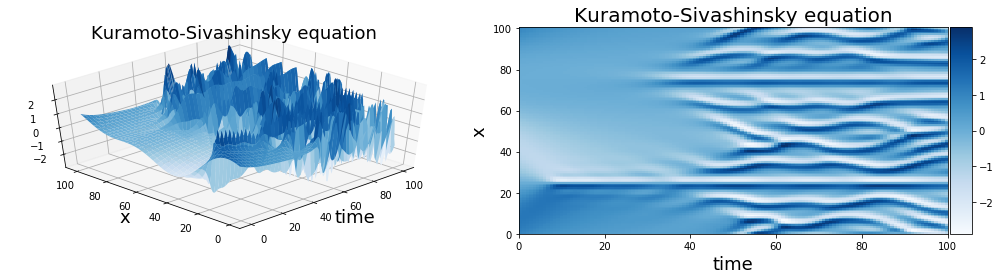

In [5]:
def printKS(time, x_vect, data, title):
    fig = plt.figure(figsize=(14, 4))

    gs = gridspec.GridSpec(1, 2)
    gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)
    ax = plt.subplot(gs[0, 0], projection='3d')
    T, XX = np.meshgrid(time, x_vect)
    h = ax.plot_surface(T, XX, data.T, cmap='Blues')
    ax.view_init(elev=45., azim=-135)
    ax.set_xlabel('time', fontsize = 18)
    ax.set_ylabel('x', fontsize = 18)
    ax.set_title(title, fontsize=18)

    t_max=t[-1]
    t_min=t[0]

    x_max=x[-1]
    x_min=x[0]

    ax = plt.subplot(gs[0, 1])
    h = ax.imshow(u.T, interpolation='nearest', cmap='Blues',
                  extent=[0, t_max, 0, L*np.pi],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.04)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('time', fontsize = 18)
    ax.set_ylabel('x', fontsize = 18)
    ax.set_title('Kuramoto-Sivashinsky equation', fontsize = 20)

    gs.tight_layout(fig)
    

def printKS_and_error(time, x_vect, data_analytic, data_nn, title, error_title):
    
    t_max=t[-1]
    t_min=t[0]

    x_max=x[-1]
    x_min=x[0]

    fig = plt.figure(figsize=(14, 4))

    gs = gridspec.GridSpec(1, 2)
    gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)
    ax = plt.subplot(gs[0, 0], projection='3d')
    T, XX = np.meshgrid(time, x_vect)

    h = ax.plot_surface(T, XX, data_nn.T, cmap='Blues')
    ax.view_init(elev=45., azim=-135)
    ax.set_xlabel('time', fontsize = 18)
    ax.set_ylabel('x', fontsize = 18)
    ax.set_title(title, fontsize = 18)


    ax = plt.subplot(gs[0, 1])
    h = ax.imshow(story_num.T, interpolation='nearest', cmap='Blues',
                  extent=[0, t_max, 0, L*np.pi],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.04)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('time', fontsize = 18)
    ax.set_ylabel('x', fontsize = 18)
    ax.set_title(title, fontsize = 18)

    gs.tight_layout(fig)

    fig = plt.figure(figsize=(14, 4))

    gs = gridspec.GridSpec(1, 2)
    gs.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.3, hspace=0.3)
    ax = plt.subplot(gs[0, 0], projection='3d')

    h = ax.plot_surface(T, XX, (data_nn.T - data_analytic.T), cmap='Blues')
    ax.view_init(elev=45., azim=-135)
    ax.set_xlabel('time', fontsize = 18)
    ax.set_ylabel('x', fontsize = 18)
    ax.set_title(error_title, fontsize = 18)


    ax = plt.subplot(gs[0, 1])
    h = ax.imshow((story_num.T - u.T), interpolation='nearest', cmap='Blues',
                  extent=[0, t_max, 0, L*np.pi],
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.04)
    fig.colorbar(h, cax=cax)
    ax.set_xlabel('time', fontsize = 18)
    ax.set_ylabel('x', fontsize = 18)
    ax.set_title(error_title, fontsize = 18)

    gs.tight_layout(fig)
    
printKS(t,x,u, "Kuramoto-Sivashinsky equation")

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, n):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n, int(n*2)),
            nn.ReLU(),
            nn.Linear(int(n*2), int(n*2)),
            nn.ReLU(),
            nn.Linear(int(n*2), int(n*2)),
            nn.ReLU(),
            nn.Linear(int(n*2), n),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    
    
class NeuralNetworkStrict(nn.Module):
    def __init__(self, n):
        super(NeuralNetworkStrict, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n, int(n/2)),
            nn.ReLU(),
            nn.Linear(int(n/2), int(n/2)),
            nn.ReLU(),
            nn.Linear(int(n/2), int(n/2)),
            nn.ReLU(),
            nn.Linear(int(n/2), n),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
    
class NeuralNetworkLong(nn.Module):
    def __init__(self, n):
        super(NeuralNetworkLong, self).__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n, int(n*2)),
            nn.ReLU(),
            nn.Linear(int(n*2), int(n*2)),
            nn.ReLU(),
            nn.Linear(int(n*2), int(n*2)),
            nn.ReLU(),
            nn.Linear(int(n*2), int(n*2)),
            nn.ReLU(),
            nn.Linear(int(n*2), int(n*2)),
            nn.ReLU(),
            nn.Linear(int(n*2), n),
        )

    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits    
    
    
model = NeuralNetwork(n_x).to("cpu")
model.double()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [7]:
u_train, u_test, y_train, y_test = train_test_split(uu[:-1,:], uu[1:,:],  test_size=0.2, random_state=113)

tu_train = torch.from_numpy(u_train)
ty_train = torch.from_numpy(y_train)
tu_test = torch.from_numpy(u_test)
ty_test = torch.from_numpy(y_test)
tx = torch.from_numpy(x)

In [8]:
class KuraSiva(Dataset):
    def __init__(self, data, result, x_dimension, targets=None):
        reduced_input_result = data
        reduced_output_result = result
        #m = torch.ones(reduced_input_result.shape)*x_dimension
        #self.input_ = torch.concat((reduced_input_result,m), axis=1)
        self.input_ = reduced_input_result
        self.output_ = reduced_output_result
        print(self.input_.shape)
        print(self.output_.shape)
        

    def __len__(self):
        return len(self.input_)

    def __getitem__(self, idx):
        return self.input_[idx,:],self.output_[idx,:]
    


k_train = KuraSiva(tu_train,ty_train, tx)
k_test = KuraSiva(tu_test,ty_test, tx)

learning_rate = 1e-4
batch_size = 16
epochs = 5000
train_dataloader = DataLoader(k_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(k_test, batch_size=batch_size,  shuffle=False)


loss_fn = nn.MSELoss(reduction='sum') # questa potrebbe funzionare per regressione
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model_local, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model_local(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        optimizer.step()

#        if batch % 10 == 0:
#            loss, current = loss.item(), batch * len(X)
#            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
            
def test_loop(dataloader, model_local, loss_fn, print_flag, lv):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model_local(X)
            test_loss += loss_fn(pred, y).item()
            correct += np.sqrt((np.power(pred - y,2).sum())/len(y))
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()


    if(print_flag):
        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Root Means Square Error: {(100*correct):>0.1f}, Avg loss: {test_loss:>8f} \n")
        lv.append(test_loss)
      
    
loss_vector = []
    
    
if(os.path.isfile('ks_weights')):
    model.load_state_dict(torch.load('ks_weights'))
    print(model.eval())
else:
    for tt in range(epochs):
        pp = False
        if(tt%100 == 0):
            print(f"Epoch {tt+1}\n-------------------------------")
            pp = True
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loop(test_dataloader, model, loss_fn, pp, loss_vector)
        torch.save(model.state_dict(), 'ks_weights')

        
model.eval()

torch.Size([100, 128])
torch.Size([100, 128])
torch.Size([25, 128])
torch.Size([25, 128])
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
  )
)


NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128, bias=True)
  )
)

In [9]:

ic_tensor = torch.from_numpy(init_cond)
#ic_tensor_conc = torch.concat((ic_tensor,tx), axis=0)
story = ic_tensor.view(1,len(ic_tensor))
old_res = ic_tensor
for i in range(len(t)-1):
    with torch.no_grad():
        ic_tensor_conc = torch.concat((old_res,tx), axis=0)
        res = model(old_res)
        old_res = res
        story = torch.cat((story,res.view(1,len(res))),0)


story_num = story.numpy()


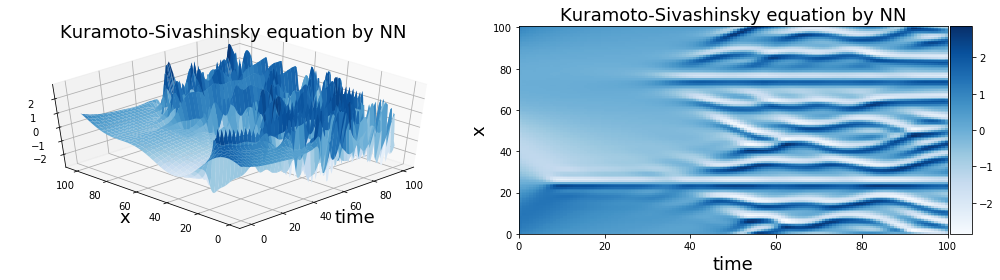

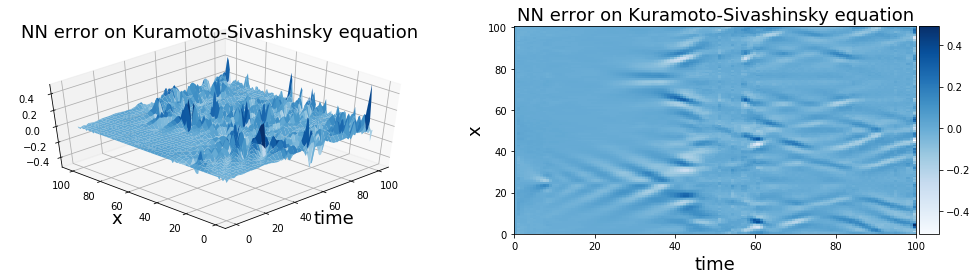

In [10]:
printKS_and_error(t, x, u, story_num,"Kuramoto-Sivashinsky equation by NN", "NN error on Kuramoto-Sivashinsky equation")

Trying the same NN with a different initial condition, to forecast the KS trend

In [11]:
L = 32
n_x = 128
x, u, t = KS(L, n_x, 200, 10)
init_cond = np.cos(x / 10) * (1 + np.sin(x / 10)) # initial function

n_t = len(t)
t_max = t[-1]

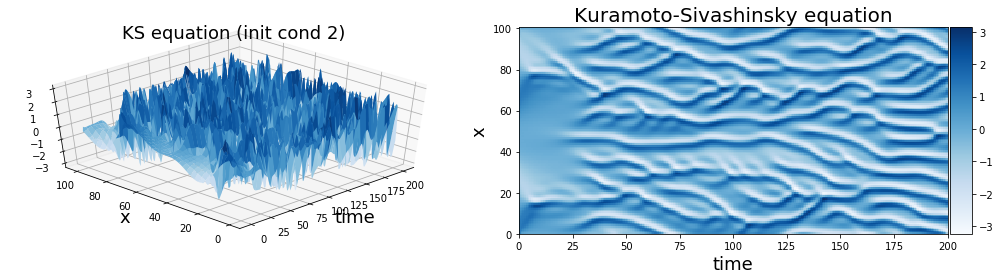

In [12]:
printKS(t,x,u, "KS equation (init cond 2)")

In [13]:
ic_tensor = torch.from_numpy(init_cond)
story = ic_tensor.view(1,len(ic_tensor))
old_res = ic_tensor
for i in range(len(t)-1):
    with torch.no_grad():
        ic_tensor_conc = torch.concat((old_res,tx), axis=0)
        res = model(old_res)
        old_res = res
        story = torch.cat((story,res.view(1,len(res))),0)


story_num = story.numpy()

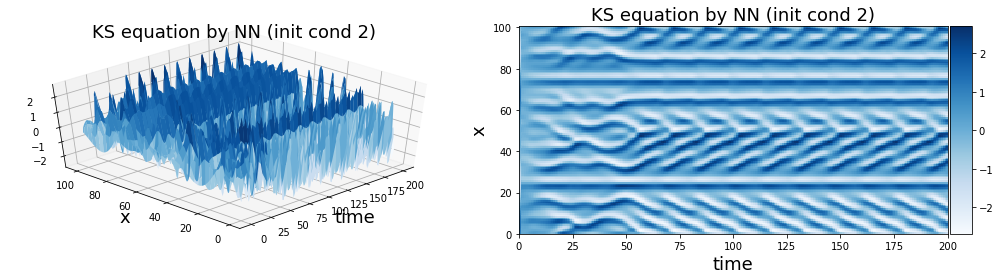

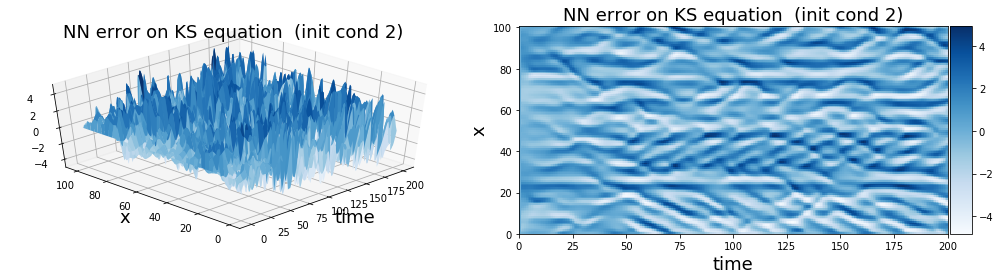

In [14]:
printKS_and_error(t, x, u, story_num,"KS equation by NN (init cond 2)", "NN error on KS equation  (init cond 2)")

Trying with a NN with more hidden layer.

In [15]:
L = 32
n_x = 128

x, uu, tt = KS(L, n_x, 100, 16)
init_cond = np.cos(x / 16) * (1 + np.sin(x / 16)) # initial function
t = tt
u = uu

u_train, u_test, y_train, y_test = train_test_split(uu[:-1,:], uu[1:,:],  test_size=0.2, random_state=113)

tu_train = torch.from_numpy(u_train)
ty_train = torch.from_numpy(y_train)
tu_test = torch.from_numpy(u_test)
ty_test = torch.from_numpy(y_test)
tx = torch.from_numpy(x)

k_train = KuraSiva(tu_train,ty_train, tx)
k_test = KuraSiva(tu_test,ty_test, tx)

learning_rate = 1e-4
batch_size = 16
epochs = 5000
train_dataloader = DataLoader(k_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(k_test, batch_size=batch_size,  shuffle=False)



model_long = NeuralNetworkLong(n_x).to("cpu")
model_long.double()

loss_fn_long = nn.MSELoss(reduction='sum') # questa potrebbe funzionare per regressione
optimizer_long = torch.optim.Adam(model_long.parameters(), lr=learning_rate)


if(os.path.isfile('ks_long_weights')):
    model_long.load_state_dict(torch.load('ks_long_weights'))
    print(model_long.eval())
else:
    for tt in range(epochs):
        pp = False
        if(tt%100 == 0):
            print(f"Epoch {tt+1}\n-------------------------------")
            pp = True
        train_loop(train_dataloader, model_long, loss_fn_long, optimizer_long)
        test_loop(test_dataloader, model_long, loss_fn_long, pp, loss_vector)
        torch.save(model_long.state_dict(), 'ks_long_weights')
        
model_long.eval()

torch.Size([100, 128])
torch.Size([100, 128])
torch.Size([25, 128])
torch.Size([25, 128])
NeuralNetworkLong(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=128, bias=True)
  )
)


NeuralNetworkLong(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=128, bias=True)
  )
)

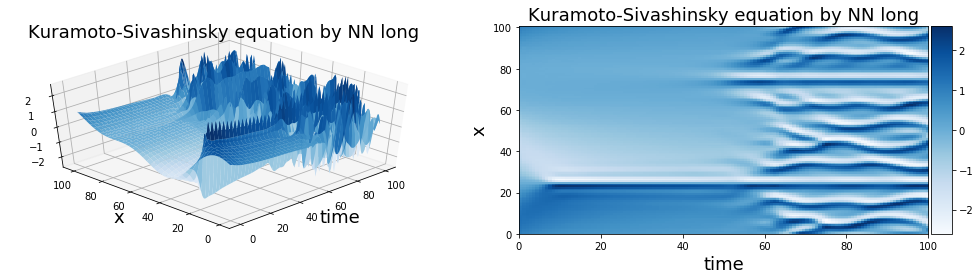

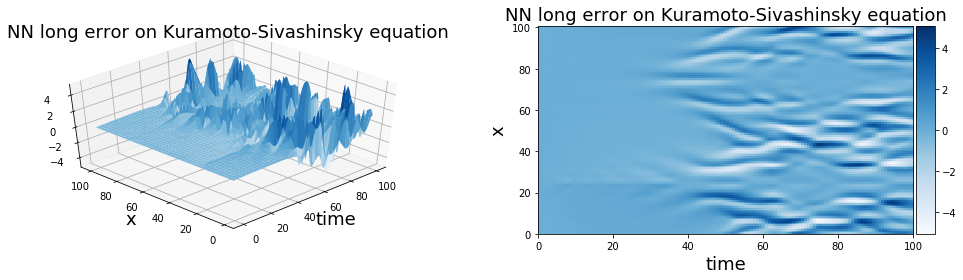

In [16]:
ic_tensor = torch.from_numpy(init_cond)
#ic_tensor_conc = torch.concat((ic_tensor,tx), axis=0)
story = ic_tensor.view(1,len(ic_tensor))
old_res = ic_tensor
for i in range(len(t)-1):
    with torch.no_grad():
        ic_tensor_conc = torch.concat((old_res,tx), axis=0)
        res = model_long(old_res)
        old_res = res
        story = torch.cat((story,res.view(1,len(res))),0)


story_num = story.numpy()
printKS_and_error(t, x, u, story_num,"Kuramoto-Sivashinsky equation by NN long", "NN long error on Kuramoto-Sivashinsky equation")

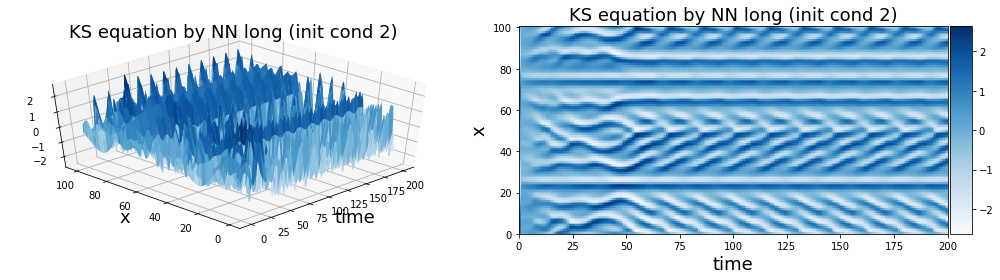

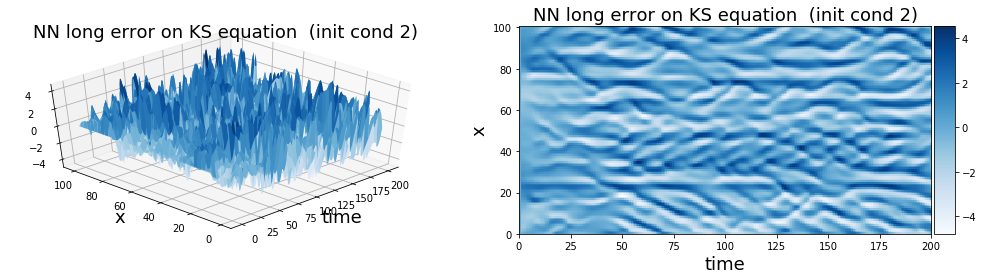

In [17]:
L = 32
n_x = 128
x, u, t = KS(L, n_x, 200, 10)
init_cond = np.cos(x / 10) * (1 + np.sin(x / 10)) # initial function

n_t = len(t)
t_max = t[-1]

ic_tensor = torch.from_numpy(init_cond)
story = ic_tensor.view(1,len(ic_tensor))
old_res = ic_tensor
for i in range(len(t)-1):
    with torch.no_grad():
        ic_tensor_conc = torch.concat((old_res,tx), axis=0)
        res = model_long(old_res)
        old_res = res
        story = torch.cat((story,res.view(1,len(res))),0)


story_num = story.numpy()
printKS_and_error(t, x, u, story_num,"KS equation by NN long (init cond 2)", "NN long error on KS equation  (init cond 2)")

Now I try with a strict version of the NN

In [18]:
L = 32
n_x = 128

x, uu, tt = KS(L, n_x, 100, 16)
init_cond = np.cos(x / 16) * (1 + np.sin(x / 16)) # initial function
t = tt
u = uu

u_train, u_test, y_train, y_test = train_test_split(uu[:-1,:], uu[1:,:],  test_size=0.2, random_state=113)

tu_train = torch.from_numpy(u_train)
ty_train = torch.from_numpy(y_train)
tu_test = torch.from_numpy(u_test)
ty_test = torch.from_numpy(y_test)
tx = torch.from_numpy(x)

k_train = KuraSiva(tu_train,ty_train, tx)
k_test = KuraSiva(tu_test,ty_test, tx)

learning_rate = 1e-4
batch_size = 16
epochs = 5000
train_dataloader = DataLoader(k_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(k_test, batch_size=batch_size,  shuffle=False)



model_strict = NeuralNetworkStrict(n_x).to("cpu")
model_strict.double()

loss_fn_strict = nn.MSELoss(reduction='sum') # questa potrebbe funzionare per regressione
optimizer_strict = torch.optim.Adam(model_strict.parameters(), lr=learning_rate)


if(os.path.isfile('ks_strict_weights')):
    model_strict.load_state_dict(torch.load('ks_strict_weights'))
    print(model_strict.eval())
else:
    for tt in range(epochs):
        pp = False
        if(tt%100 == 0):
            print(f"Epoch {tt+1}\n-------------------------------")
            pp = True
        train_loop(train_dataloader, model_strict, loss_fn_strict, optimizer_strict)
        test_loop(test_dataloader, model_strict, loss_fn_strict, pp, loss_vector)
        torch.save(model_strict.state_dict(), 'ks_strict_weights')
        
model_strict.eval()

torch.Size([100, 128])
torch.Size([100, 128])
torch.Size([25, 128])
torch.Size([25, 128])
NeuralNetworkStrict(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
  )
)


NeuralNetworkStrict(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
  )
)

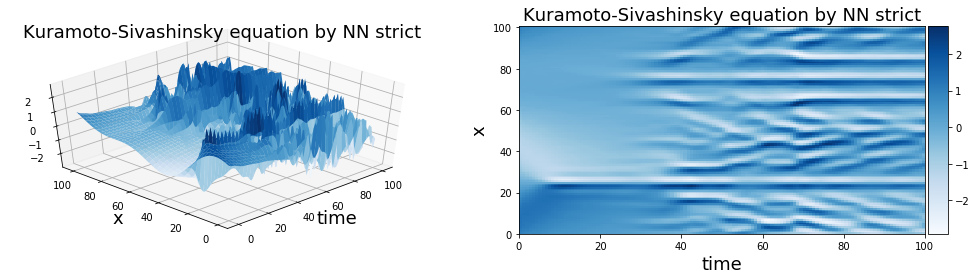

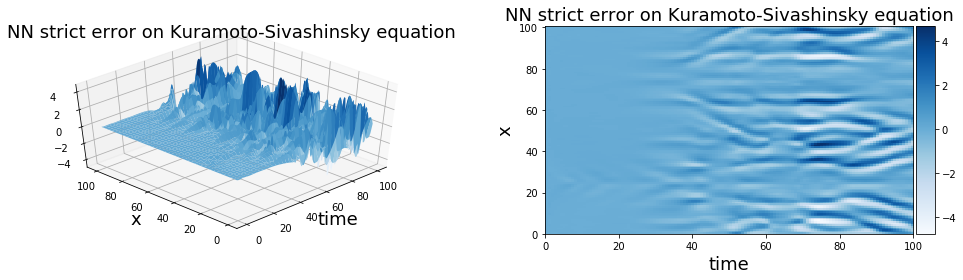

In [19]:
ic_tensor = torch.from_numpy(init_cond)
#ic_tensor_conc = torch.concat((ic_tensor,tx), axis=0)
story = ic_tensor.view(1,len(ic_tensor))
old_res = ic_tensor
for i in range(len(t)-1):
    with torch.no_grad():
        ic_tensor_conc = torch.concat((old_res,tx), axis=0)
        res = model_strict(old_res)
        old_res = res
        story = torch.cat((story,res.view(1,len(res))),0)


story_num = story.numpy()
printKS_and_error(t, x, u, story_num,"Kuramoto-Sivashinsky equation by NN strict", "NN strict error on Kuramoto-Sivashinsky equation")

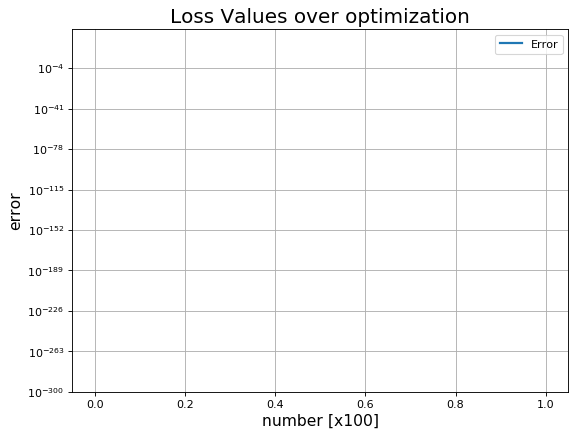

In [20]:

fig = plt.figure(2,figsize=(8, 6), dpi=80)
line1 = plt.semilogy(loss_vector, label='Error',color='tab:blue', alpha=1, linewidth=2)


plt.xlabel('number [x100]', fontsize=14)
plt.ylabel('error', fontsize=14)
plt.title('Loss Values over optimization', fontsize=18)
plt.legend(loc='upper right')
plt.grid()
plt.show()